# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
#librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor 

import warnings
warnings.filterwarnings('ignore')



In [2]:
#almacenamiento de registros en data con conversión de fechas a datetime e índice
data = pd.read_csv("/datasets/taxi.csv", parse_dates = [0], index_col=[0])

In [3]:
data.sort_index(inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


De la revisión del dataset se desprende:
1. Hay una columna, "num_orders" que no tiene datos ausentes y hay 26496 registros. Se transformo la columna datetime a tipo datetime y se tomo la misma como índice.

## Análisis

<AxesSubplot:xlabel='datetime'>

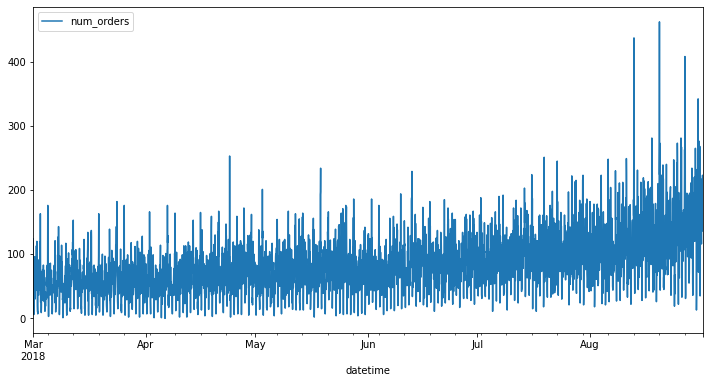

In [6]:
#Se hace resample por hora
data_resample = data.resample("1H").sum()
data_resample.plot(figsize=(12,6))

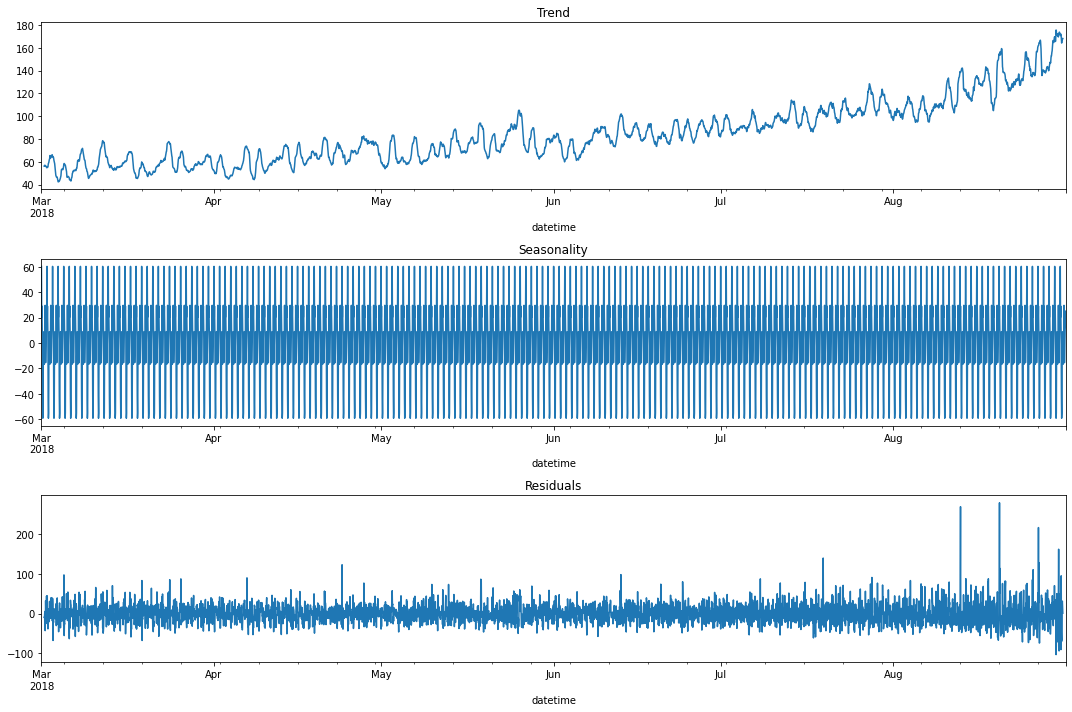

In [7]:
decomposed = seasonal_decompose(data_resample)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(),figsize=(15, 10))
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

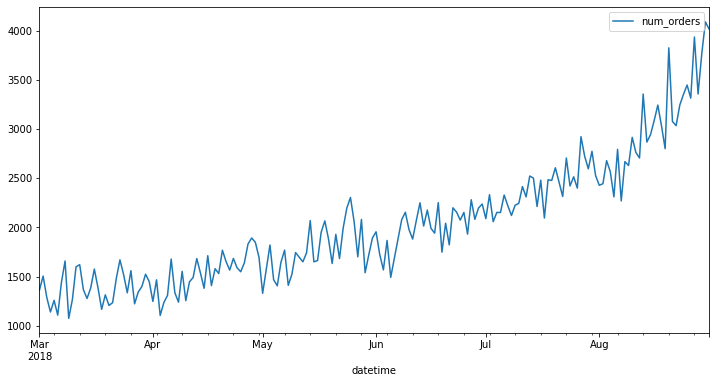

In [8]:
data_resample_d = data.resample("1D").sum()
data_resample_d.plot(figsize=(12,6))

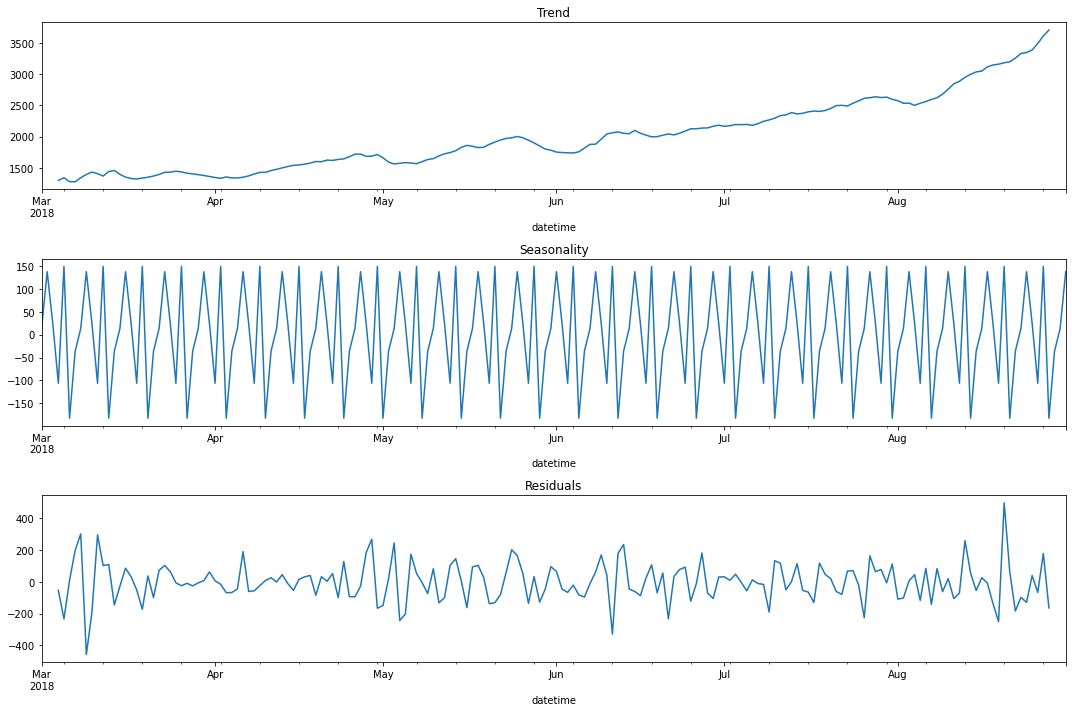

In [9]:
decomposed = seasonal_decompose(data_resample_d)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(),figsize=(15, 10))
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

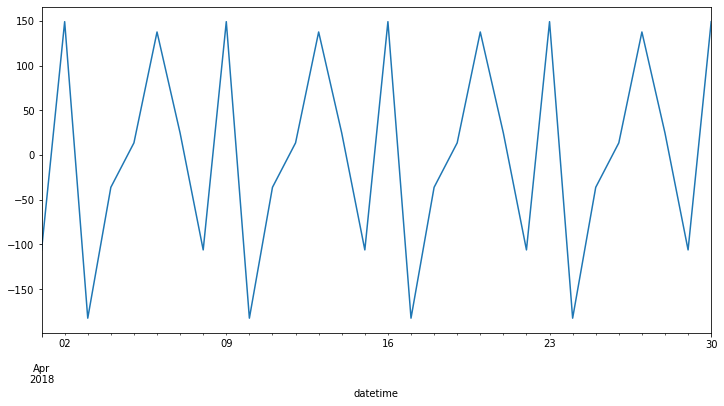

In [10]:
decomposed.seasonal["2018-04-01":"2018-04-30"].plot(figsize=(12,6))

1. Durante el mes de marzo, la frecuencia en el uso de los taxis se mantiene estable, pero a partir de mediados del mes de abril se observa un incremento progresivo, siendo agosto el mes que más alza reportó.
2. En la estacionalidad se observa que se repite un patrón con picos en el número de ordenes los días lunes (02, 09, 16, 23, 30) y viernes(06, 13, 20, 27) que coincide con el inicio del fin de semana y el inicio de la jornada laboral. y los días martes los días de menor tránsito (03, 10, 17, 24)

## Formación y Prueba

In [11]:
#función para enriquecer el dataframe
def features_nuevas(data, max_lag = 7, rolling_mean_size = 6):
       
    data["month"] = data.index.month
    data["day"] = data.index.day
    data["dayofweek"] = data.index.dayofweek
    data["hour"] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data["lag_{}".format(lag)] = data["num_orders"].shift(lag)

    data["rolling_mean"] = data["num_orders"].shift().rolling(rolling_mean_size).mean()
    return data

In [12]:
data_resample_features_nuevas = features_nuevas(data_resample)
data_resample_features_nuevas.head(8)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,65.833333
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,47.166667


In [13]:
data_resample_cleaned = data_resample_features_nuevas.dropna()
data_resample_cleaned.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,47.166667
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,35.500000
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,6.0,43.0,66.0,71.0,29.333333
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,29.833333
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,33.333333


### Definición de features y target - Split

In [14]:
#Definición de features y target
features = data_resample_cleaned.drop(["num_orders"], axis=1)
target = data_resample_cleaned["num_orders"]
#split
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [15]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((3968, 12), (3968,), (441, 12), (441,))

### Definición de funciones para cálculo de error y modelo

In [16]:
def rmse(true, pred):
    return mean_squared_error(true, pred)**0.5

r_scorer = make_scorer(rmse, greater_is_better=False)

In [17]:
def modelo(model, x_train, y_train, x_test, y_test, hiperparametros={}, scoring=None, cv=5, verbose=False):
    np.random.seed(42)
    best_rmse = 0
    start_time = time.time()
           
    #afinamiento de hiperparámetros
    gridsearch = GridSearchCV(model, param_grid=hiperparametros, scoring=scoring, cv=cv)
    gridsearch.fit(x_train, y_train)
    #ajuste del modelo con los mejores hiperparámetros
    gridsearch.best_estimator_.fit(x_train, y_train)
    #predicción
    prediccion = gridsearch.best_estimator_.predict(x_test)
    best_rmse = rmse(y_test, prediccion)
    end_time = time.time() - start_time
    return gridsearch.best_estimator_, best_rmse, np.round(end_time, 2)

### Modelo de regresión lineal

In [18]:
#Regresion lineal

lr = LinearRegression()
%time lr_model, lr_rmse, lr_tiempo = modelo(lr, features_train, target_train, features_test, target_test, hiperparametros={}, scoring=r_scorer, cv=5)
print("RMSE para", lr_model, ":", lr_rmse, "tiempo de ejecución:", lr_tiempo)

CPU times: user 66.2 ms, sys: 113 ms, total: 179 ms
Wall time: 176 ms
RMSE para LinearRegression() : 52.73988481092026 tiempo de ejecución: 0.18


### Modelo Random Forest Regressor

In [19]:
#Random forest regressor

rf = RandomForestRegressor(random_state=42)
%time forest_model, forest_rmse, forest_tiempo = modelo(rf, features_train, target_train, features_test, target_test, hiperparametros={"n_estimators": [30, 40, 50], "max_depth": [40, 50]}, scoring=r_scorer, cv=5)
print("RMSE para", forest_model, ":", forest_rmse, "tiempo de ejecución:", forest_tiempo)

CPU times: user 31.8 s, sys: 104 ms, total: 31.9 s
Wall time: 32 s
RMSE para RandomForestRegressor(max_depth=40, n_estimators=50, random_state=42) : 44.30187112339629 tiempo de ejecución: 32.01


### Modelo Decision Tree Regressor

In [20]:
#Decision Tree

dt = DecisionTreeRegressor(random_state=42)
hiperparametros_dt = {"max_depth" : list(np.arange(1,40,1)),"min_samples_split": range(2, 10, 2)}
%time decision_model, decision_rmse, decision_tiempo = modelo(dt, features_train, target_train, features_test, target_test, hiperparametros=hiperparametros_dt, scoring=r_scorer, cv=5)
print("RMSE para", decision_model, ":", decision_rmse, "tiempo de ejecución:", decision_tiempo)


CPU times: user 26.5 s, sys: 4.47 ms, total: 26.5 s
Wall time: 26.5 s
RMSE para DecisionTreeRegressor(max_depth=6, min_samples_split=4, random_state=42) : 52.47287491346537 tiempo de ejecución: 26.51


### Modelo KNeighbors Regressor

In [21]:
# Kneighbors Regressor
kn = KNeighborsRegressor()
hiperparametros_kn = {"n_neighbors" : range(1,6,1), "algorithm" : ["auto", "kd_tree", "ball_tree"], "leaf_size" : [10,30], "p" : [1,2]}
%time kn_model, kn_rmse, kn_tiempo = modelo(kn, features_train, target_train, features_test, target_test, hiperparametros=hiperparametros_kn, scoring=r_scorer, cv=5)
print("RMSE para", kn_model, ":", kn_rmse, "tiempo de ejecución:", kn_tiempo)

CPU times: user 15.6 s, sys: 76 µs, total: 15.6 s
Wall time: 15.6 s
RMSE para KNeighborsRegressor(leaf_size=10, p=1) : 58.867024906268135 tiempo de ejecución: 15.64


### Modelo LGBM

In [22]:
lgbm = LGBMRegressor(random_state=42)
hiper_lgbm = {"learning_rate": [0.1, 0.5], "max_depth": [5, 7, 10], "n_estimators": [500, 1000], "num_leaves": [20, 40]}

%time lgbm_model, lgbm_rmse, lgbm_tiempo = modelo(lgbm,features_train, target_train, features_test, target_test, hiperparametros=hiper_lgbm, scoring=r_scorer, cv=3 )
print("RMSE para", lgbm_model, ":", lgbm_rmse, "tiempo de ejecución:", lgbm_tiempo)

CPU times: user 2min 22s, sys: 2.33 s, total: 2min 24s
Wall time: 2min 26s
RMSE para LGBMRegressor(max_depth=7, n_estimators=500, num_leaves=20, random_state=42) : 44.778808343015235 tiempo de ejecución: 146.09


### Modelo Cat boost Regressor

In [25]:
cat = CatBoostRegressor(loss_function = "RMSE", random_state = 42)
#hiperparámetros
hiper_cat = {"iterations": [30, 50, 100], "max_depth" : [8, 10, 12], "learning_rate": [0.01, 0.5]}
%time cat_model, cat_rmse, cat_tiempo = modelo(cat, features_train, target_train, features_test, target_test, hiperparametros=hiper_cat, scoring=r_scorer, cv=3, verbose=False )
print("RMSE para", cat_model, ":", cat_rmse, "tiempo de ejecución:", cat_tiempo)

0:	learn: 38.6579133	total: 7.75ms	remaining: 225ms
1:	learn: 38.4996265	total: 18.1ms	remaining: 253ms
2:	learn: 38.3175732	total: 28.8ms	remaining: 259ms
3:	learn: 38.1407010	total: 39.7ms	remaining: 258ms
4:	learn: 37.9650765	total: 50.7ms	remaining: 254ms
5:	learn: 37.7907008	total: 61.3ms	remaining: 245ms
6:	learn: 37.6178727	total: 69.8ms	remaining: 229ms
7:	learn: 37.4400447	total: 78.1ms	remaining: 215ms
8:	learn: 37.2958445	total: 85ms	remaining: 198ms
9:	learn: 37.1288634	total: 92.9ms	remaining: 186ms
10:	learn: 36.9703038	total: 100ms	remaining: 173ms
11:	learn: 36.8117770	total: 108ms	remaining: 161ms
12:	learn: 36.6639527	total: 115ms	remaining: 150ms
13:	learn: 36.5331876	total: 123ms	remaining: 141ms
14:	learn: 36.3898264	total: 135ms	remaining: 135ms
15:	learn: 36.2324919	total: 147ms	remaining: 128ms
16:	learn: 36.0985195	total: 156ms	remaining: 119ms
17:	learn: 35.9467310	total: 165ms	remaining: 110ms
18:	learn: 35.8115074	total: 174ms	remaining: 101ms
19:	learn: 35.

In [24]:
resultados = pd.DataFrame({"model": ["LinearRegression", "RandomForestRegressor",  "DecisionTreeRegressor", "KNeighbors Regressor","LGBM", "CatBoostRegressor"],
              "best_rmse_test_data": [lr_rmse, forest_rmse, decision_rmse, kn_rmse, lgbm_rmse, cat_rmse], 
              "tiempo de ejecucion (s)": [lr_tiempo, forest_tiempo, decision_tiempo, kn_tiempo, lgbm_tiempo, cat_tiempo],
              })
resultados

,model,best_rmse_test_data,tiempo de ejecucion (s)
0,LinearRegression,52.739885,0.18
1,RandomForestRegressor,44.301871,32.01
2,DecisionTreeRegressor,52.472875,26.51
3,KNeighbors Regressor,58.867025,15.64
4,LGBM,44.778808,146.09
5,CatBoostRegressor,45.247308,136.34


Los modelos seleccionados fueron evaluados en la data Test:

1. LGBM y Random Forest son los modelos que mejores resultados arrojan con la salvedad de que en el LGBM el tiempo de ejecución es mayor.
2. El modelo KNeighbors regressor es el que más alto valor de RMSE arrojó aunque fue el más rápido después del modelo de regresión lineal.
3. El modelo CatBoost Regressor fue el que en tercer lugar arrojó mejores resultados.


## Conclusiones

1. Se tiene un dataframe con 26496 registros y la columna "num_orders". 
2. No hay datos ausentes.
3. Se realizó un resample por 1H y por 1D detectándose una tendencia a incrementarse a partir de marzo con incrementos puntuales los días lunes y viernes y descenso en las solicitudes de taxi los días martes.
4. LGBM y Random Forest son los modelos que mejores resultados arrojan en su predicción con la salvedad de que en el LGBM el tiempo de ejecución es mayor.
2. El modelo KNeighbors regressor es el que más alto valor de RMSE arrojó aunque fue el más rápido después del modelo de regresión lineal.
3. El modelo CatBoost Regressor fue el que en tercer lugar arrojó mejores resultados.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48